# Voice Recognition.

## Install dependencies

In [12]:
!pip install -q transformers datasets torchaudio torchcodec soundfile

import os
from google.colab import userdata

# Getting Kaggle credentials and setting in environment
os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.5 MB/s eta 0:00:00


## Download dataset

In [14]:
import os
import torch
import torchaudio
from torchaudio.datasets import SPEECHCOMMANDS
from torch.utils.data import DataLoader, Dataset

# 1. Descarga (Tu método)
os.makedirs('./temp_data', exist_ok=True)
dataset_raw = SPEECHCOMMANDS(root='./temp_data', url='speech_commands_v0.02', download=True, subset='training')

# 2. Definir etiquetas para el juego
# Mapeamos las palabras clave. Todo lo que no esté aquí será "unknown"
target_labels = ["up", "down", "left", "right", "stop", "go", "yes", "no"]
label2id = {label: i for i, label in enumerate(target_labels)}
label2id["unknown"] = len(target_labels) # Clase para otras palabras
id2label = {i: l for l, i in label2id.items()}

### Visualize

Para visualizar el audio y su espectro (espectrograma), usaremos matplotlib. El espectrograma es crucial porque convierte el sonido en una imagen, permitiendo que modelos de visión artificial (como las CNN) "lean" el sonido.

¿Qué estás viendo exactamente?
Waveform (Onda): Representa la presión del aire a lo largo del tiempo. Es la forma más pura del sonido, pero difícil de analizar para una IA porque pequeñas variaciones de ruido cambian mucho la forma.

Espectrograma: Es una representación en 2D donde:

El eje X es el tiempo.

El eje Y es la frecuencia (graves abajo, agudos arriba).

El color (brillo) representa la energía o volumen en esa frecuencia específica.

Label: Es la etiqueta (como "yes", "no", "up") que usaremos como objetivo para que nuestra red aprenda a clasificar.

Concepto técnico útil
Para el procesamiento de lenguaje natural y voz, solemos usar la escala Mel, que es una escala no lineal de frecuencias que imita cómo el oído humano percibe el sonido (escuchamos mejor los cambios en frecuencias bajas que en las muy altas).



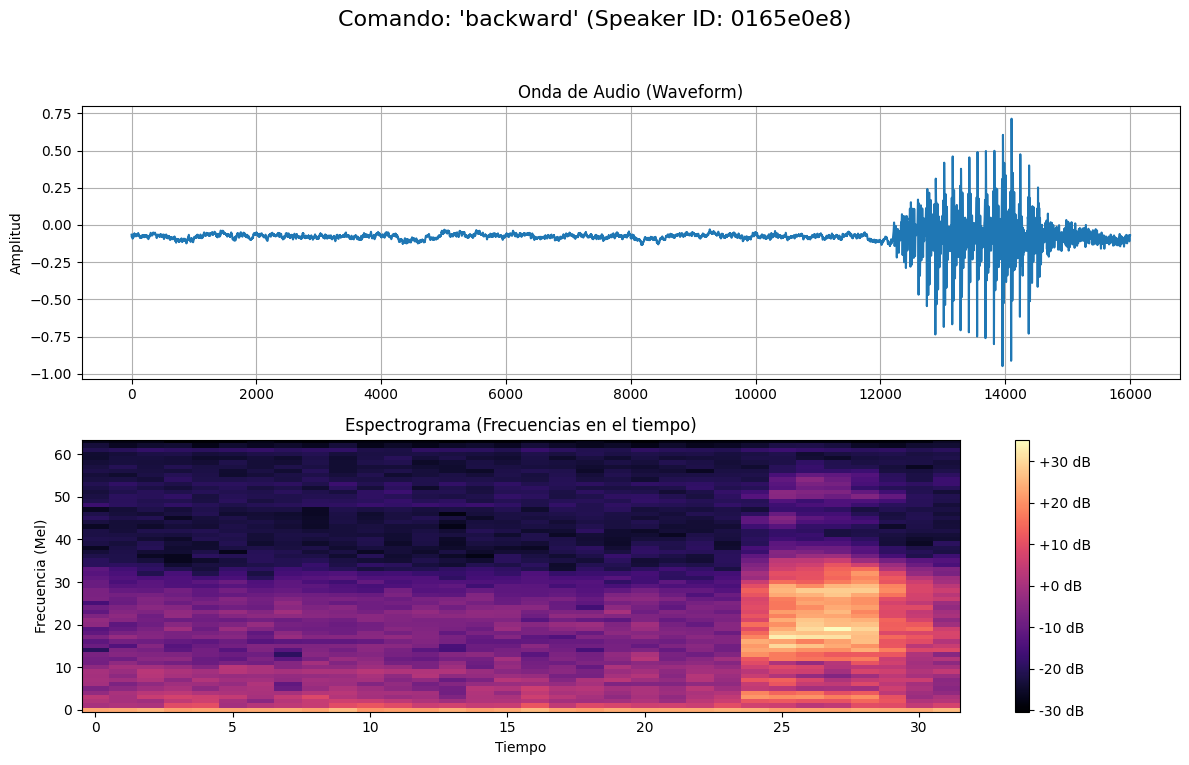

In [17]:
import matplotlib.pyplot as plt
import torchaudio
import torchaudio.transforms as T
import torch

# 1. Seleccionamos un ejemplo (por ejemplo, el índice 0)
waveform, sample_rate, label, speaker_id, _ = dataset_raw[0]

# 2. Creamos la transformación para el Espectrograma
# Usamos MelSpectrogram porque es el estándar para voz humana
spectrogram_transform = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_mels=64,
    n_fft=1024,
    hop_length=512
)
spectrogram = spectrogram_transform(waveform)

# 3. Visualización
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
fig.suptitle(f"Comando: '{label}' (Speaker ID: {speaker_id})", fontsize=16)

# Graficar la Onda (Waveform)
axes[0].plot(waveform.t().numpy())
axes[0].set_title("Onda de Audio (Waveform)")
axes[0].set_ylabel("Amplitud")
axes[0].grid(True)

# Graficar el Espectrograma
# Aplicamos logaritmo (db) para que sea más fácil de ver
spec_db = T.AmplitudeToDB()(spectrogram)
im = axes[1].imshow(spec_db[0].numpy(), origin='lower', aspect='auto', cmap='magma')
axes[1].set_title("Espectrograma (Frecuencias en el tiempo)")
axes[1].set_ylabel("Frecuencia (Mel)")
axes[1].set_xlabel("Tiempo")
fig.colorbar(im, ax=axes[1], format="%+2.0f dB")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 4. Escuchar el audio (Solo en Colab)
from IPython.display import Audio
Audio(waveform.numpy(), rate=sample_rate)

### Construcción y Entrenamiento del Modelo